# Introduction

This study used Apache Spark and its ML Library. This is to compare some of the Apache Spark's Classification Algorithms in an easy way to make predictions. 
**A quick summary:**

* Import Libraries
* Build Spark Session
* Data Load
* Data Exploration & Preparation
* Feature Engineering
* Data Scaling
* Data Split
* Build, Train & Evaluate Model


In [3]:
#install Apache Spark
!pip install pyspark --quiet

## Importing Libraries

In [4]:
#Generic Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Apache Spark Libraries
import pyspark
from pyspark.sql import SparkSession

#Apache Spark ML CLassifier Libraries
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,NaiveBayes

#Apache Spark Evaluation Library
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Apache Spark Features libraries
from pyspark.ml.feature import StandardScaler,StringIndexer, VectorAssembler, VectorIndexer, OneHotEncoder

#Apache Spark Pipelin Library
from pyspark.ml import Pipeline

# Apache Spark `DenseVector`
from pyspark.ml.linalg import DenseVector

#Data Split Libraries
import sklearn
from sklearn.model_selection import train_test_split


#Tabulating Data
from tabulate import tabulate

#Garbage
import gc

## Build Spark Session

In [5]:
#Building Spark Session
spark = (SparkSession.builder
                  .appName('Apache Spark Beginner Tutorial')
                  .config("spark.executor.memory", "1G")
                  .config("spark.executor.cores","4")
                  .getOrCreate())

/opt/conda/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [6]:
spark.sparkContext.setLogLevel('INFO')

In [7]:
spark.version

'3.2.3'

## Data Load

In [8]:
url = '../input/iris-dataset/iris.csv'

data = spark.read.format("csv") \
       .option("header", "true") \
       .option("inferSchema","true")\
       .load(url) 

data.cache() #for faster re-use

DataFrame[sepal_length: double, sepal_width: double, petal_length: double, petal_width: double, species: string]

## Data Exploration & Preparation

In [9]:
#Total records 
data.count()

150

In [10]:
#Data Type
data.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [11]:
#Display records
data.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



In [12]:
#Records per Species
data.groupBy('species').count().show()

+----------+-----+
|   species|count|
+----------+-----+
| virginica|   50|
|versicolor|   50|
|    setosa|   50|
+----------+-----+



In [13]:
#Dataset Summary Stats
data.describe().show()

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  species|
+-------+------------------+-------------------+------------------+------------------+---------+
|  count|               150|                150|               150|               150|      150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|     null|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|     null|
|    min|               4.3|                2.0|               1.0|               0.1|   setosa|
|    max|               7.9|                4.4|               6.9|               2.5|virginica|
+-------+------------------+-------------------+------------------+------------------+---------+



Inorder to make predictions via the newly created model, the Species aka Label column should be a numerical value instead of string. To achieve this we shall use String Indexing on the Species columns

In [14]:
#String Indexing the Species column
SIndexer = StringIndexer(inputCol='species', outputCol='species_indx')
data = SIndexer.fit(data).transform(data)

#Inspect the dataset
data.show(5)


+------------+-----------+------------+-----------+-------+------------+
|sepal_length|sepal_width|petal_length|petal_width|species|species_indx|
+------------+-----------+------------+-----------+-------+------------+
|         5.1|        3.5|         1.4|        0.2| setosa|         0.0|
|         4.9|        3.0|         1.4|        0.2| setosa|         0.0|
|         4.7|        3.2|         1.3|        0.2| setosa|         0.0|
|         4.6|        3.1|         1.5|        0.2| setosa|         0.0|
|         5.0|        3.6|         1.4|        0.2| setosa|         0.0|
+------------+-----------+------------+-----------+-------+------------+
only showing top 5 rows



## Feature Engineering

The Spark model needs two columns: “label” and “features” to conduct feature engineering because to focus on the mechanics of training the model in Spark. Hence, creating a seperate dataframe with re-ordered columns, then defining an input data using Dense Vector will aid in the process. A Dense Vector is a local vector that is backed by a double array that represents its entry values. In other words, it's used to store arrays of values for use in PySpark.


In [15]:
#creating a seperate dataframe with re-ordered columns
df = data.select("species_indx","sepal_length", "sepal_width", "petal_length", "petal_width")

#Inspect the dataframe
df.show(5)

+------------+------------+-----------+------------+-----------+
|species_indx|sepal_length|sepal_width|petal_length|petal_width|
+------------+------------+-----------+------------+-----------+
|         0.0|         5.1|        3.5|         1.4|        0.2|
|         0.0|         4.9|        3.0|         1.4|        0.2|
|         0.0|         4.7|        3.2|         1.3|        0.2|
|         0.0|         4.6|        3.1|         1.5|        0.2|
|         0.0|         5.0|        3.6|         1.4|        0.2|
+------------+------------+-----------+------------+-----------+
only showing top 5 rows



**Note:** Observe that the species column which is our label (aka Target) is now at beginning of the dataframe

In [16]:
# Define the `input_data` as Dense Vector
input_data = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

**Note:** Observe the definition of the Dense Vector. So,when a new indexed dataframe is created(below) the machine understands that the first column is a Label (Target) and the remaining columns are Features.

In [17]:
# Creating a new Indexed Dataframe
df_indx = spark.createDataFrame(input_data, ["label", "features"])

In [18]:
#view the indexed dataframe
df_indx.show(5)

+-----+-----------------+
|label|         features|
+-----+-----------------+
|  0.0|[5.1,3.5,1.4,0.2]|
|  0.0|[4.9,3.0,1.4,0.2]|
|  0.0|[4.7,3.2,1.3,0.2]|
|  0.0|[4.6,3.1,1.5,0.2]|
|  0.0|[5.0,3.6,1.4,0.2]|
+-----+-----------------+
only showing top 5 rows



## Data Scaling

This is also known as Feature Scaling. It is a method of normalizing the features of the data. Scaling can make a difference between a weak machine learning model and a better one. 

A Standard Scaler to scale our feature data. Apache Spark has a Standard Scaler library to do the job.

In [19]:
#Initialize Standard Scaler
stdScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

#Fit the Standard Scaler to the indexed Dataframe
scaler = stdScaler.fit(df_indx)

#Transform the dataframe
df_scaled =scaler.transform(df_indx)

In [20]:
#Viewing the Scaled Data
df_scaled.show(5)

+-----+-----------------+--------------------+
|label|         features|     features_scaled|
+-----+-----------------+--------------------+
|  0.0|[5.1,3.5,1.4,0.2]|[6.15892840883878...|
|  0.0|[4.9,3.0,1.4,0.2]|[5.9174018045706,...|
|  0.0|[4.7,3.2,1.3,0.2]|[5.67587520030241...|
|  0.0|[4.6,3.1,1.5,0.2]|[5.55511189816831...|
|  0.0|[5.0,3.6,1.4,0.2]|[6.03816510670469...|
+-----+-----------------+--------------------+
only showing top 5 rows



In [21]:
#Dropping the Features column
df_scaled = df_scaled.drop("features")

## Data Split

Before building a model, the data was split our scaled dataset into training & test sets. 
Training Dataset = 90%
Test Dataset = 10%

In [22]:
train_data, test_data = df_scaled.randomSplit([0.9, 0.1], seed = 12345)

In [23]:
#Inspect Training Data
train_data.show(5)

+-----+--------------------+
|label|     features_scaled|
+-----+--------------------+
|  0.0|[5.19282199176603...|
|  0.0|[5.31358529390013...|
|  0.0|[5.31358529390013...|
|  0.0|[5.31358529390013...|
|  0.0|[5.43434859603422...|
+-----+--------------------+
only showing top 5 rows



## Build, Train & Evaluate Model

In this step, multiple models such as decision tree, random forest and Naive Bayes, train them on the scaled dataset and then compare their accuracy.

In [24]:
model = ['Decision Tree','Random Forest','Naive Bayes']
model_results = []

In [25]:
# -- Decision Tree Classifier --

dtc = DecisionTreeClassifier(labelCol="label", featuresCol="features_scaled")          #instantiate the model
dtc_model = dtc.fit(train_data)                                                        #train the model
dtc_pred = dtc_model.transform(test_data)                                              #model predictions

#Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dtc_acc = evaluator.evaluate(dtc_pred)
#print("Decision Tree Classifier Accuracy =", '{:.2%}'.format(dtc_acc))
model_results.extend([[model[0],'{:.2%}'.format(dtc_acc)]])                               #appending to list
    

In [26]:
# -- Random Forest Classifier --

rfc = RandomForestClassifier(labelCol="label", featuresCol="features_scaled", numTrees=10)          #instantiate the model
rfc_model = rfc.fit(train_data)                                                                     #train the model
rfc_pred = rfc_model.transform(test_data)                                                           #model predictions

#Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rfc_acc = evaluator.evaluate(rfc_pred)
#print("Random Forest Classifier Accuracy =", '{:.2%}'.format(rfc_acc))
model_results.extend([[model[1],'{:.2%}'.format(rfc_acc)]])                                            #appending to list

In [27]:
# -- Naive Bayes Classifier --

nbc = NaiveBayes(smoothing=1.0,modelType="multinomial", labelCol="label",featuresCol="features_scaled")    #instantiate the model
nbc_model = nbc.fit(train_data)                                                                          #train the model
nbc_pred = nbc_model.transform(test_data)                                                                #model predictions

#Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nbc_acc = evaluator.evaluate(nbc_pred)
#print("Naive Bayes Accuracy =", '{:.2%}'.format(nbc_acc))
model_results.extend([[model[2],'{:.2%}'.format(nbc_acc)]])                                            #appending to list

In [28]:
#freeing memory
gc.collect()

499

Tabulating the results.

In [29]:
print (tabulate(model_results, headers=["Classifier Models", "Accuracy"]))

Classifier Models    Accuracy
-------------------  ----------
Decision Tree        90.91%
Random Forest        90.91%
Naive Bayes          100.00%


> > 

In [31]:
import bokeh
bokeh.sampledata.download()

Creating /root/.bokeh directory
Creating /root/.bokeh/data directory
Using data directory: /root/.bokeh/data
Downloading: CGM.csv (1589982 bytes)
   1589982 [100.00%]
Downloading: US_Counties.zip (3171836 bytes)
   3171836 [100.00%]
Unpacking: US_Counties.csv
Downloading: us_cities.json (713565 bytes)
    713565 [100.00%]
Downloading: unemployment09.csv (253301 bytes)
    253301 [100.00%]
Downloading: AAPL.csv (166698 bytes)
    166698 [100.00%]
Downloading: FB.csv (9706 bytes)
      9706 [100.00%]
Downloading: GOOG.csv (113894 bytes)
    113894 [100.00%]
Downloading: IBM.csv (165625 bytes)
    165625 [100.00%]
Downloading: MSFT.csv (161614 bytes)
    161614 [100.00%]
Downloading: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip (4816256 bytes)
   4816256 [100.00%]
Unpacking: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.csv
Downloading: gapminder_fertility.csv (64346 bytes)
     64346 [100.00%]
Downloading: gapminder_population.csv (94509 bytes)
     94509 [100.00%]
Downloading: gapminder_life_e

In [37]:
# importing the modules
from bokeh.sampledata.iris import flowers
from bokeh.plotting import figure, show, output_file

# file to save the model
output_file("gfg.html")

# instantiating the figure object
graph = figure(title="Iris Visualization")

# labeling the x-axis and the y-axis
graph.xaxis.axis_label = "Length (in cm)"
graph.yaxis.axis_label = "Width (in cm)"

# plotting for setosa petals
x = flowers[flowers["species"] == "setosa"]["petal_length"]
y = flowers[flowers["species"] == "setosa"]["petal_width"]
marker = "circle_cross"
line_color = "blue"
fill_color = "lightblue"
fill_alpha = 0.4
size = 10
legend_label = "setosa petals"
graph.scatter(x, y,
              marker=marker,
              line_color=line_color,
              fill_color=fill_color,
              fill_alpha=fill_alpha,
              size=size,
              legend_label=legend_label)

# plotting for setosa sepals
x = flowers[flowers["species"] == "setosa"]["sepal_length"]
y = flowers[flowers["species"] == "setosa"]["sepal_width"]
marker = "square_cross"
line_color = "blue"
fill_color = "lightblue"
fill_alpha = 0.4
size = 10
legend_label = "setosa sepals"
graph.scatter(x, y,
              marker=marker,
              line_color=line_color,
              fill_color=fill_color,
              fill_alpha=fill_alpha,
              size=size,
              legend_label=legend_label)

# plotting for versicolor petals
x = flowers[flowers["species"] == "versicolor"]["petal_length"]
y = flowers[flowers["species"] == "versicolor"]["petal_width"]
marker = "circle_cross"
line_color = "yellow"
fill_color = "lightyellow"
fill_alpha = 0.4
size = 10
legend_label = "versicolor petals"
graph.scatter(x, y,
              marker=marker,
              line_color=line_color,
              fill_color=fill_color,
              fill_alpha=fill_alpha,
              size=size,
              legend_label=legend_label)

# plotting for versicolor sepals
x = flowers[flowers["species"] == "versicolor"]["sepal_length"]
y = flowers[flowers["species"] == "versicolor"]["sepal_width"]
marker = "square_cross"
line_color = "yellow"
fill_color = "lightyellow"
fill_alpha = 0.4
size = 10
legend_label = "versicolor sepals"
graph.scatter(x, y,
              marker=marker,
              line_color=line_color,
              fill_color=fill_color,
              fill_alpha=fill_alpha,
              size=size,
              legend_label=legend_label)

# plotting for virginica petals
x = flowers[flowers["species"] == "virginica"]["petal_length"]
y = flowers[flowers["species"] == "virginica"]["petal_width"]
marker = "circle_cross"
line_color = "red"
fill_color = "lightcoral"
fill_alpha = 0.4
size = 10
legend_label = "virginica petals"
graph.scatter(x, y,
              marker=marker,
              line_color=line_color,
              fill_color=fill_color,
              fill_alpha=fill_alpha,
              size=size,
              legend_label=legend_label)

# plotting for virginica sepals
x = flowers[flowers["species"] == "virginica"]["sepal_length"]
y = flowers[flowers["species"] == "virginica"]["sepal_width"]
marker = "square_cross"
line_color = "red"
fill_color = "lightcoral"
fill_alpha = 0.4
size = 10
legend_label = "virginica sepals"
graph.scatter(x, y,
              marker=marker,
              line_color=line_color,
              fill_color=fill_color,
              fill_alpha=fill_alpha,
              size=size,
              legend_label=legend_label)

# relocating the legend table to
# avoid abstruction of the graph
graph.legend.location = "top_left"

# displaying the model
show(graph)


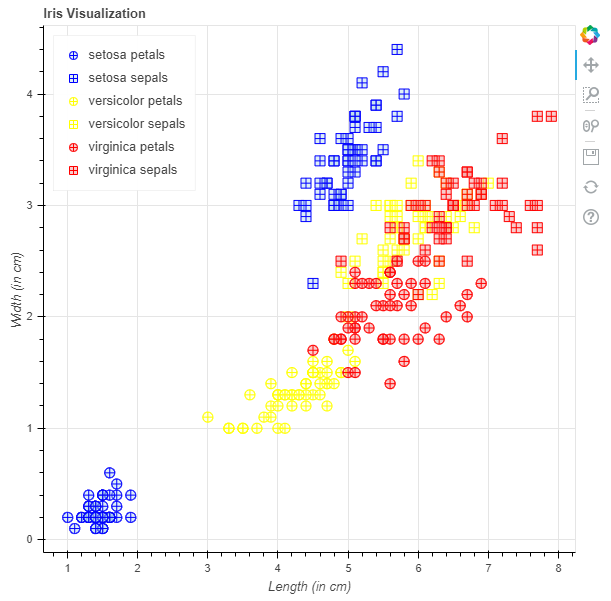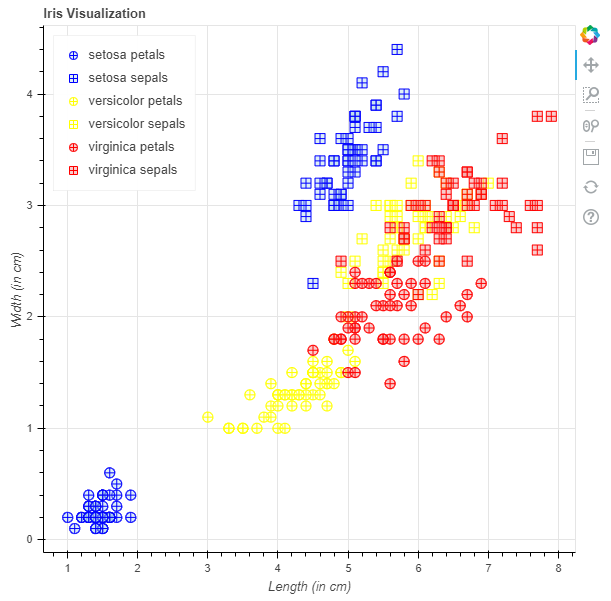

In [ ]:
# importing the modules
from bokeh.sampledata.iris import flowers
from bokeh.plotting import figure, show, output_file

# file to save the model
output_file("gfg.html")

# instantiating the figure object
graph = figure(title="Iris Visualization")

# labeling the x-axis and the y-axis
graph.xaxis.axis_label = "Petal Length (in cm)"
graph.yaxis.axis_label = "Petal Width (in cm)"

# plotting for setosa petals
x = flowers[flowers["species"] == "setosa"]["petal_length"]
y = flowers[flowers["species"] == "setosa"]["petal_width"]
color = "blue"
legend_label = "setosa petals"
graph.circle(x, y,
			color=color,
			legend_label=legend_label)

# plotting for versicolor petals
x = flowers[flowers["species"] == "versicolor"]["petal_length"]
y = flowers[flowers["species"] == "versicolor"]["petal_width"]
color = "yellow"
legend_label = "versicolor petals"
graph.circle(x, y,
			color=color,
			legend_label=legend_label)

# plotting for virginica petals
x = flowers[flowers["species"] == "virginica"]["petal_length"]
y = flowers[flowers["species"] == "virginica"]["petal_width"]
color = "red"
legend_label = "virginica petals"
graph.circle(x, y,
			color=color,
			legend_label=legend_label)

# relocating the legend table to
# avoid abstruction of the graph
graph.legend.location = "top_left"

# displaying the model
show(graph)


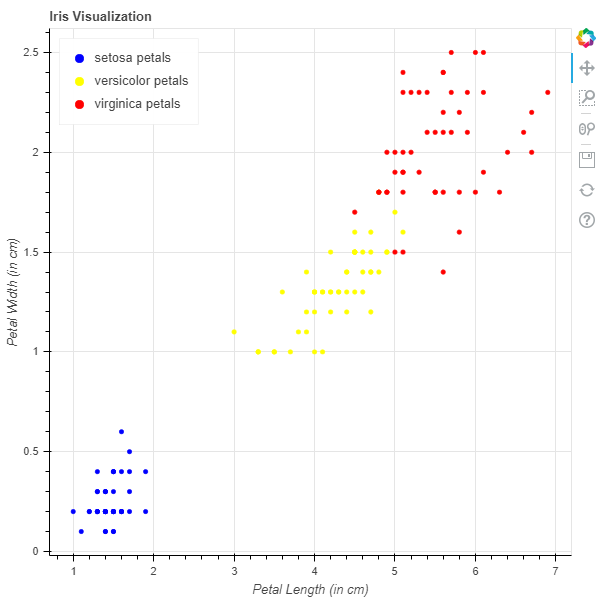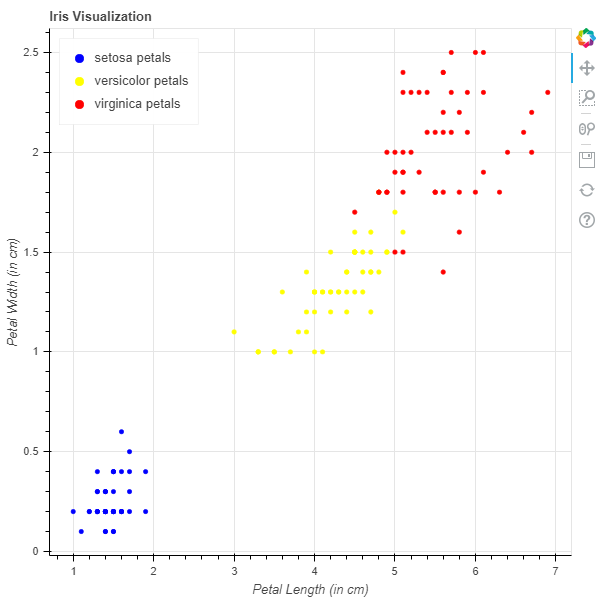